In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

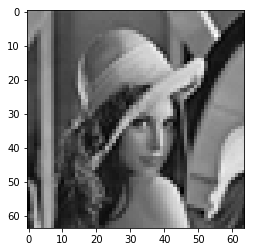

In [2]:
# Diffusion function
g = lambda s: 1/(1+s)


# Create a random test image
def generate_random2D(N, M):
    # Generate image of 4 squares
    I = np.zeros((N+2, M+2))
    I[:N//2+1, :M//2+1] = 80
    I[:N//2+1, -(M//2+1):] = 190
    I[-(N//2+1):, :M//2+1] = 140
    I[-(N//2+1):, -(M//2+1):] = 230
    
    # Add noise to picture
    I[1:-1, 1:-1] += np.random.rand(N,M)*3
    return I

def load_image( infilename ) :
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data

def image_display(V, n, m, cmap = "gray"):
    image = V.reshape(((n, m)))
    plt.imshow(image, cmap)
    plt.show()

I = load_image("lena-64x64.jpg")

# Spatial discretization
M = 62
N = 62
K = (M+2) * (N+2)
dx = 1/(M+1)
dy = 1/(N+1)


# Number of iteratinos, adn timestep
T = 100
dt = 1e-11
r = dt/(2*(dx**2 + dy**2))

# Generate random image
# I = generate_random2D(N, M)


# Initiate grid
U = np.zeros((T, K))
U[0] = I.reshape(K)

plt.imshow(U[0].reshape(N+2, M+2), cmap = "gray")
plt.show()

In [3]:
# Block matrix x-derivative
Bx = -1 * np.eye(M+2, k = -1) + np.eye(M+2, k = 1)
Bx[0, :2] = [-2, 2]
Bx[-1, -2:] = [-2, 2]

# Differentiation matrix x-direction
Dx = np.zeros((K, K))
for i in range(N+2):
    Dx[i*(M+2):(i+1)*(M+2), i*(M+2):(i+1)*(M+2)] = Bx  
Dx /= 2*dx

# Differnetiation matrix y-direction
Dy = -np.eye(K, k = -(M+2)) + np.eye(K, k = M+2)
Dy[:(M+2), :2*(M+2)] = np.hstack((-2*np.identity(M+2), 2*np.identity(M+2)))
Dy[-(M+2):, -2*(M+2):] = np.hstack((-2*np.identity(M+2), 2*np.identity(M+2)))
Dy /= 2*dy

In [4]:
# Construction matrix
cshape = (N*(M+2), K)
bshape = (M, M+2) # Block matrixshape

Ξx = np.zeros(cshape)
Γx = np.zeros(cshape)
Ωx = np.zeros(cshape)

Ξy = np.eye(*cshape) + np.eye(*cshape, k = M+2) 
Ωy = -np.eye(*cshape) - 2 * np.eye(*cshape, k = M+2) - np.eye(*cshape, k = 2*(M+2))
Γy = np.eye(*cshape, k = M+2) + np.eye(*cshape, k = 2*(M+2))

Xx = np.eye(*bshape) + np.eye(*bshape, k = 1)
Mx = - np.eye(*bshape) - 2*np.eye(*bshape, k = 1) - np.eye(*bshape, k = 2)
Fx = np.eye(*bshape, k = 1) + np.eye(*bshape, k = 2)

for i in range(N+2):
    Ξx[i*M:(i+1)*M, i*(M+2):(i+1)*(M+2)] = Xx

for i in range(N+2):
    Ωx[i*M:(i+1)*M, i*(M+2):(i+1)*(M+2)] = Mx

for i in range(N+2):
    Γx[i*M:(i+1)*M, i*(M+2):(i+1)*(M+2)] = Fx

In [5]:
Ax = np.zeros((K, K))
Ay = np.zeros((K, K))

for it in range(T-1):
    if it%10 == 0:
        print(it)
    G = g(Dx.dot(U[it])**2 + Dy.dot(U[it])**2)
    ξx = Ξx.dot(U[it])
    ωx = Ωx.dot(U[it])
    γx = Γx.dot(U[it])

    ξy = Ξy.dot(U[it])
    ωy = Ωy.dot(U[it])
    γy = Γy.dot(U[it])
    
    for j in range(N+2):
        row = j*(M+2)
        for l in range(1, M+1):
            Ax[row+l, row+l-1: row+l+2] = [ξx[i*M+l-1], ωx[i*M+l-1], γx[i*M+l-1]]

    for j in range(M+2, (N+1)*(M+2)):
        if j % (M+2)  or j + 1== 0:
            continue
        Ay[j, j-(M+2):j] = ξy[j-(M+2)]*np.eye(1, M+2)
        Ay[j, j:j+M+2] = ωy[j-(M+2)]*np.eye(1, M+2)
        Ay[j, j+M+2] = γy[j-(M+2)]
    
    Ax /= 2*dx**2
    Ay /= 2*dy**2
    
    U[it+1] = (np.identity(K) - r * (Ax+ Ay)).dot(U[it])

0
10
20
30
40
50
60
70
80
90


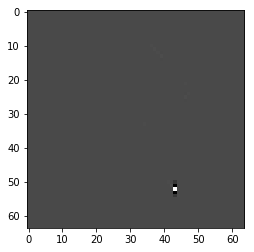

In [6]:
plt.imshow(U[-1].reshape(N+2, M+2), cmap = "gray") 
plt.show()

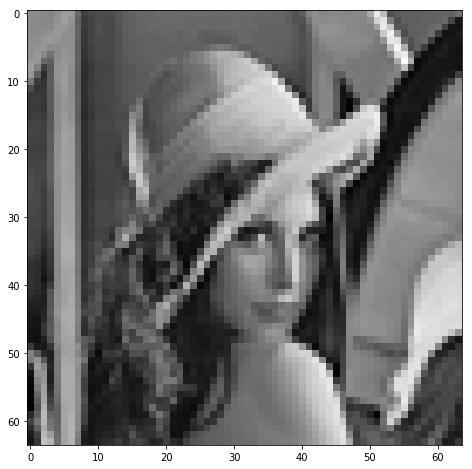

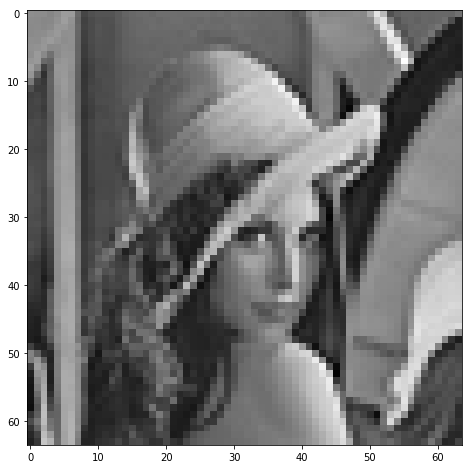

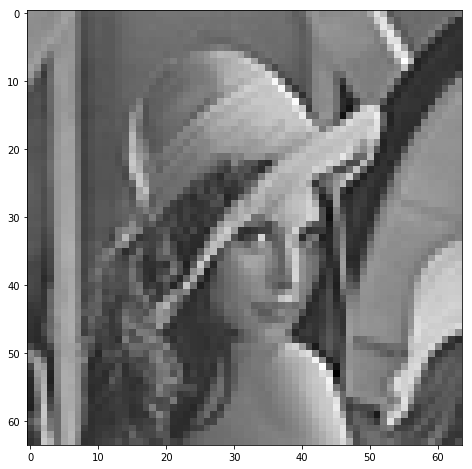

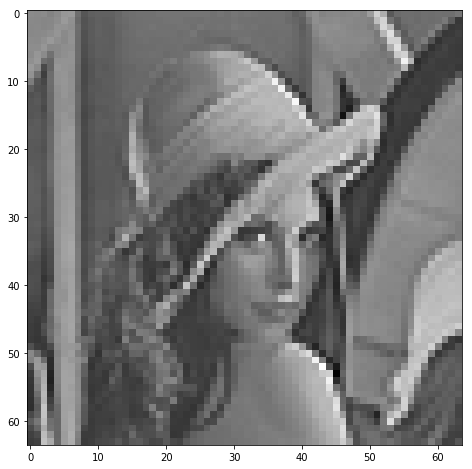

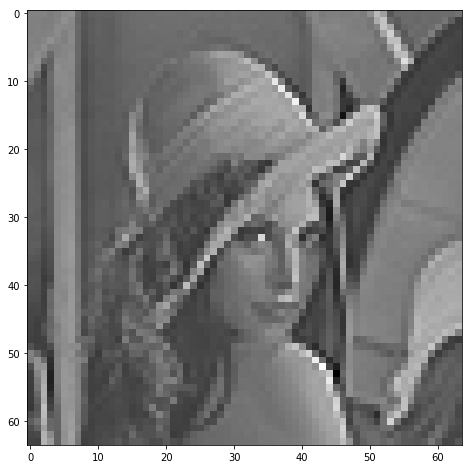

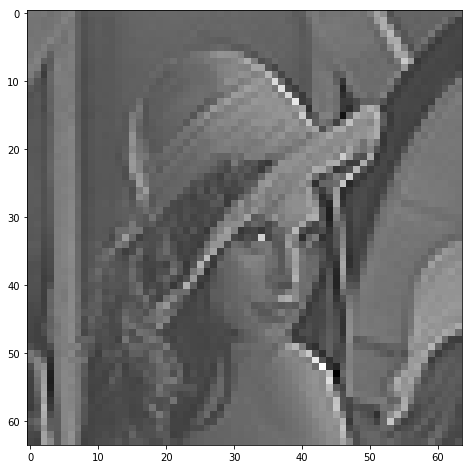

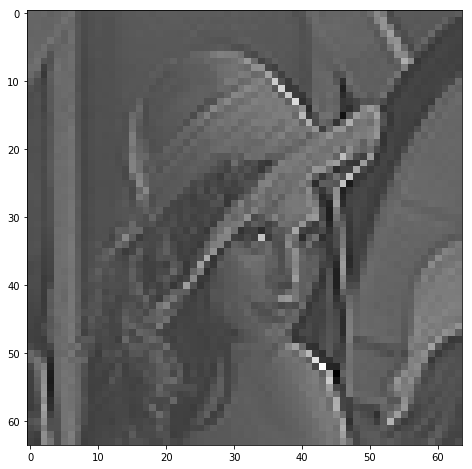

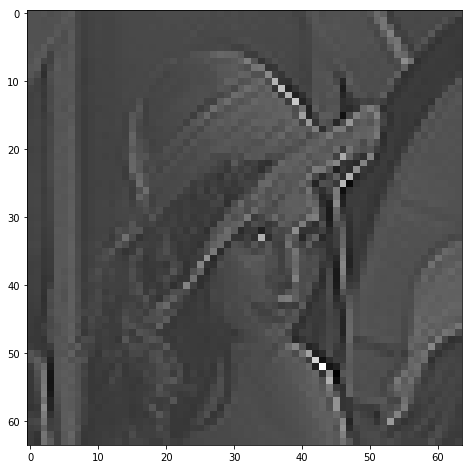

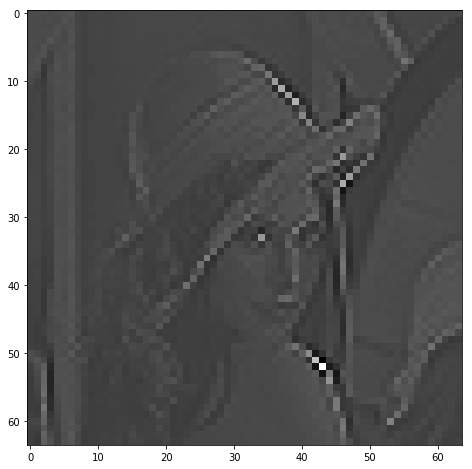

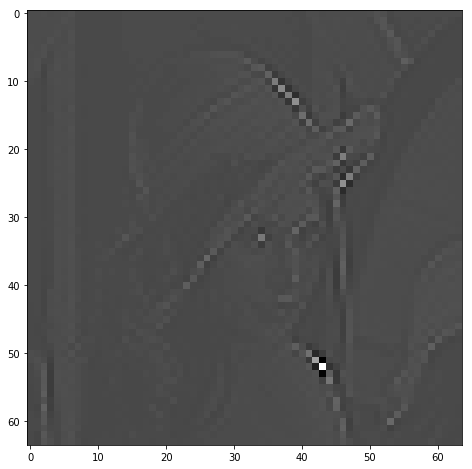

In [7]:
for i in range(10):
    plt.figure(figsize=(12,8))
    plt.imshow(U[i*10].reshape(N+2, M+2), cmap = "gray")
    plt.show()